In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import pathlib
import time
import datetime
import numpy as np
import scipy.ndimage
from matplotlib.colors import ListedColormap

from matplotlib import pyplot as plt
from IPython import display

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [6]:
# Path to the .rar file
rar_file_path = "/content/drive/MyDrive/filtered_model_data.rar"

# Destination folder for extracted files
extract_to = "/content/myData"

# Ensure the destination directory exists
os.makedirs(extract_to, exist_ok=True)

# Extract using unrar
!unrar x -r {rar_file_path} {extract_to}

Streaming output truncated to the last 5000 lines.
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_aug26.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug3257.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug49.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug498.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug821.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_3_NoInf_NoReflowN.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_3_NoInf_NoReflowN_randAug1814.npy      99%

In [7]:
  # Paths to the images and masks directories
train_images_path = "/content/myData/filtered_model_data/images/train"
train_masks_path = "/content/myData/filtered_model_data/masks/train"
test_images_path = "/content/myData/filtered_model_data/images/test"
test_masks_path = "/content/myData/filtered_model_data/masks/test"

# List and sort files to ensure they match
train_image_files = sorted(os.listdir(train_images_path))
train_mask_files = sorted(os.listdir(train_masks_path))
test_image_files = sorted(os.listdir(test_images_path))
test_mask_files = sorted(os.listdir(test_masks_path))

In [8]:
def load_dataset(images_path, masks_path):
    images = []
    masks = []
    filenames = []

    # List all files in sorted order to ensure proper alignment
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    for img_file, mask_file in zip(image_files, mask_files):
        # Full paths
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Load images and masks as NumPy arrays
        img = np.load(img_path)  # Shape: (H, W) or (H, W, C)
        mask = np.load(mask_path)  # Shape: (H, W) or (H, W, C)

        # Append to lists
        images.append(img)
        masks.append(mask)
        filenames.append(img_file)


    # Convert lists to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)  # Shape: (N, H, W, 1)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)  # Shape: (N, H, W, 1)

    return images, masks, filenames


In [9]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

In [10]:
# Load dataset
train_images_tensor, train_masks_tensor, train_filenames = load_dataset(train_images_path, train_masks_path)
test_images_tensor, test_masks_tensor, test_filenames = load_dataset(test_images_path, test_masks_path)
train_images_tensor = tf.expand_dims(train_images_tensor, axis=-1)
train_masks_tensor = tf.expand_dims(train_masks_tensor, axis=-1)
test_images_tensor = tf.expand_dims(test_images_tensor, axis=-1)
test_masks_tensor = tf.expand_dims(test_masks_tensor, axis=-1)



# Check shapes
print(f"Train Images Tensor Shape: {train_images_tensor.shape}, dtype: {train_images_tensor.dtype}")
print(f"Train Masks Tensor Shape: {train_masks_tensor.shape}, dtype: {train_masks_tensor.dtype}")
print(f"Test Images Tensor Shape: {test_images_tensor.shape}, dtype: {test_images_tensor.dtype}")
print(f"Test Masks Tensor Shape: {test_masks_tensor.shape}, dtype: {test_masks_tensor.dtype}")

Train Images Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Train Masks Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Test Images Tensor Shape: (98, 128, 128, 1), dtype: <dtype: 'float32'>
Test Masks Tensor Shape: (98, 128, 128, 1), dtype: <dtype: 'float32'>


In [11]:
# Check counts after augmentation
inf_count = sum(1 for f in train_filenames if '_Inf_' in f)
noinf_count = sum(1 for f in train_filenames if '_NoInf_' in f)
print(f"Inf/NoInf Balance: {inf_count} vs {noinf_count}")

reflowy_count = sum(1 for f in train_filenames if 'NoReflowY' in f)
reflown_count = sum(1 for f in train_filenames if 'NoReflowN' in f)
print(f"NoReflowY/NoReflowN Balance: {reflowy_count} vs {reflown_count}")

Inf/NoInf Balance: 2501 vs 2499
NoReflowY/NoReflowN Balance: 2291 vs 2709


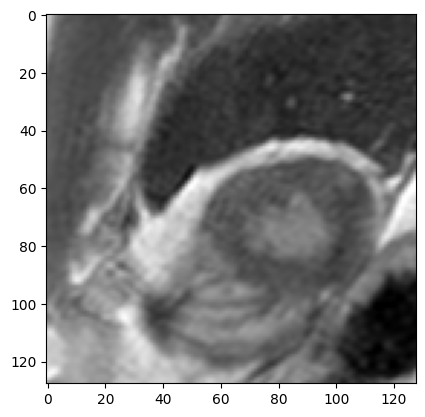

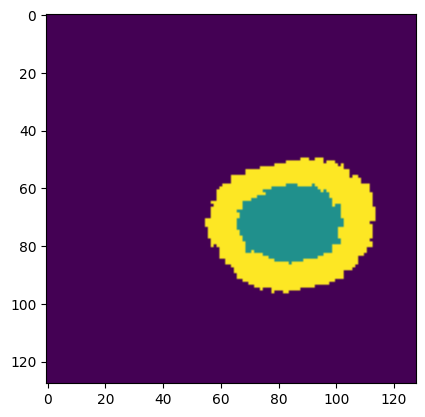

In [12]:
re = train_images_tensor[100]
inp = train_masks_tensor[100]
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re, cmap='gray')
plt.figure()
plt.imshow(inp)

In [13]:
print(f"Image value range: min={np.min(re)}, max={np.max(re)}")

Image value range: min=1789.9481201171875, max=3152.206787109375


In [14]:
# The facade training set consist of 400 images
BUFFER_SIZE = len(train_images_tensor)
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [15]:
# Normalizing the images to [-1, 1]
def normalize(image):
  min_val = np.min(image)
  max_val = np.max(image)

  if max_val == min_val:  # Avoid division by zero
      return np.zeros_like(image)  # If constant image, return all zeros in [-1,1] range

  return 2 * (image - min_val) / (max_val - min_val) - 1

In [16]:
train_images_tensor = normalize(train_images_tensor)
test_images_tensor = normalize(test_images_tensor)

In [17]:
print(train_images_tensor.shape)

(5000, 128, 128, 1)


In [18]:
print(f"Image value range: min={np.min(test_images_tensor[30])}, max={np.max(test_images_tensor[30])}")

Image value range: min=-1.0, max=1.0


In [19]:
# Create tf.data.Dataset objects for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_masks_tensor, train_images_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_masks_tensor, test_images_tensor))

# Optional: Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Train dataset size: {len(train_images_tensor)}")
print(f"Test dataset size: {len(test_images_tensor)}")

Train dataset size: 5000
Test dataset size: 98


In [20]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [21]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [22]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, 4),  # (batch_size, 32, 32, 128)
        downsample(256, 4),  # (batch_size, 16, 16, 256)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(256, 4),  # (batch_size, 16, 16, 512)
        upsample(128, 4),  # (batch_size, 32, 32, 256)
        upsample(64, 4),  # (batch_size, 64, 64, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 128, 128, 1)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
generator = Generator()
generator.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 512) │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 2, 2, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 4, 4, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4,      │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 8, 8, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8,      │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 16, 16,    │  4,195,328 │ concatenate_1[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 32, 32,    │  1,049,088 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64, 64,    │    262,400 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ sequential_10[0]

 Total params: 29,245,697 (111.56 MB)

 Trainable params: 29,238,913 (111.54 MB)

 Non-trainable params: 6,784 (26.50 KB)

(1, 128, 128, 1)


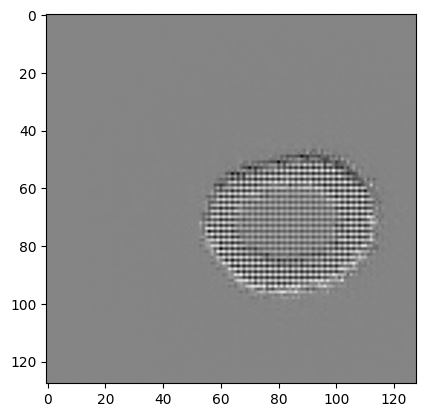

In [24]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
print(gen_output.shape)
plt.imshow(gen_output[0, ...],cmap="gray")

In [25]:
LAMBDA = 100

In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(disc_generated_output, gen_output, target, input_mask):
    # Original GAN loss component
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Create weight matrix for different regions
    weights = tf.where(input_mask == 3.0, 26.0, 1.0)  # Infarction (26x)
    weights = tf.where(input_mask == 4.0, 90.0, weights)  # No-reflow (90x)
    weights = tf.where(input_mask == 2.0, 11.0, weights)  # Normal myocardium (11x)
    weights = tf.where(input_mask == 1.0, 7.0, weights)  # Cavity (7x)

    # Expand weights to match image dimensions [batch, H, W, 1]
    weights = tf.expand_dims(weights, axis=-1)

    # Weighted L1 loss calculation
    l1_loss = tf.reduce_mean(weights * tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 128, 128, 2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 32, 32, 128)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 512)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

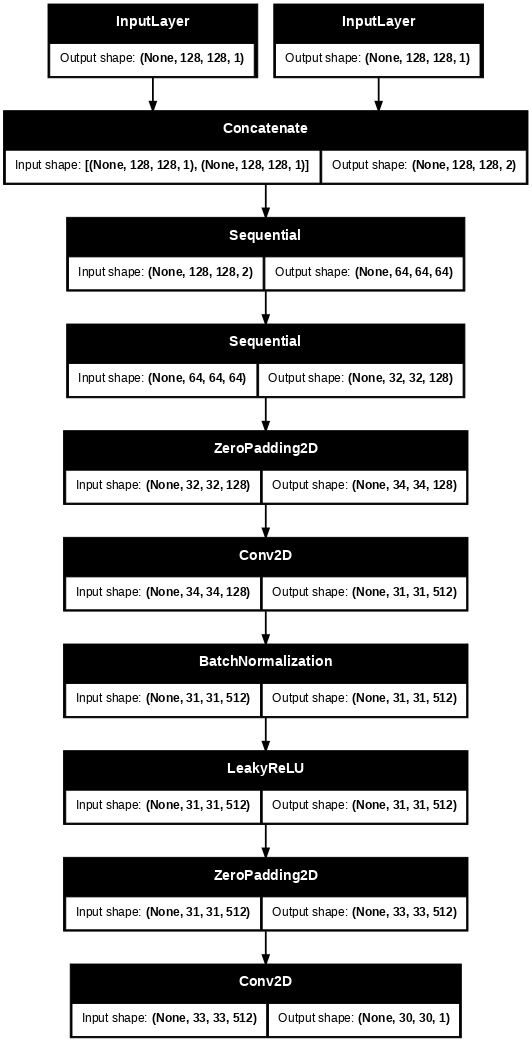

In [29]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

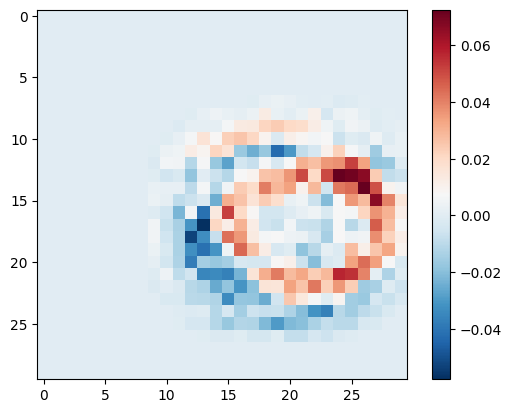

In [30]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
# Define checkpoint directory inside Google Drive
checkpoint_dir = '/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define the checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=40)
# Best-loss checkpoint folder (one best only)
best_checkpoint_prefix = '/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/checkpoints_pix2pix_best/last_last_best_ckpt'
best_checkpoint_manager = tf.train.CheckpointManager(checkpoint, best_checkpoint_prefix, max_to_keep=1)

In [34]:
# First, check for the latest checkpoint from your manager
latest_ckpt = checkpoint_manager.latest_checkpoint

if latest_ckpt:
    checkpoint.restore(latest_ckpt)
    print(f"Restored from {latest_ckpt}")
else:
    print("No checkpoint found. Initializing from scratch.")

Restored from /content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/ckpt/ckpt/ckpt-150


In [35]:
log_dir = "/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/")

In [36]:
def generate_images(model, test_input, tar):
    test_input = tf.squeeze(test_input, axis=0)  # Remove batch dim
    tar = tf.squeeze(tar, axis=0)  # Remove batch dim
    prediction = model(tf.expand_dims(test_input, axis=0), training=True)
    prediction = tf.squeeze(prediction, axis=0)  # Remove batch dim after prediction

    cmap_mask = ListedColormap(['black', 'white', 'gray', 'red', 'yellow'])

    plt.figure(figsize=(15, 15))
    display_list = [test_input, tar, prediction]
    titles = ['Input Mask', 'Ground Truth (Grayscale)', 'Predicted Image (Grayscale)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])

        if i == 0:
            # Use the custom colormap for the mask
            plt.imshow(display_list[i], cmap=cmap_mask, vmin=0, vmax=4)
        else:
            # Use grayscale for ground truth and prediction
            plt.imshow(display_list[i], cmap='gray', vmin=-1, vmax=1)

        plt.axis('off')

    plt.show()


In [37]:
best_avg_gen_total_loss = np.inf  # Set initial best loss to infinity

In [38]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target, input_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

    # Return the losses (no need for .numpy() inside @tf.function)
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss


In [39]:
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(steps_history, gen_total_loss_history, label='Generator Total Loss')
    plt.plot(steps_history, gen_gan_loss_history, label='Generator GAN Loss')
    plt.plot(steps_history, gen_l1_loss_history, label='Generator L1 Loss')
    plt.plot(steps_history, disc_loss_history, label='Discriminator Loss')

    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()


In [40]:
import pandas as pd

# At the top-level, track how many rows (steps) were loaded from old data
loss_history_path = "/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/loss.csv"
gen_total_loss_history = []
gen_gan_loss_history = []
gen_l1_loss_history = []
disc_loss_history = []
steps_history = []
num_saved = 0

if os.path.exists(loss_history_path):
    df = pd.read_csv(loss_history_path)
    steps_history = df['Step'].tolist()
    gen_total_loss_history = df['Gen_Total_Loss'].tolist()
    gen_gan_loss_history = df['Gen_GAN_Loss'].tolist()
    gen_l1_loss_history = df['Gen_L1_Loss'].tolist()
    disc_loss_history = df['Disc_Loss'].tolist()
    num_saved = len(df)
    print(f"Loaded previous loss history, continuing from step {steps_history[-1] if steps_history else 0}")
else:
    print("No previous loss history found, starting fresh.")

def save_loss_to_drive():
    """Saves only new loss history since last save to CSV file in Google Drive."""
    global num_saved
    # We'll save only the entries after 'num_saved'
    loss_data = {
        "Step": steps_history[num_saved:],
        "Gen_Total_Loss": gen_total_loss_history[num_saved:],
        "Gen_GAN_Loss": gen_gan_loss_history[num_saved:],
        "Gen_L1_Loss": gen_l1_loss_history[num_saved:],
        "Disc_Loss": disc_loss_history[num_saved:]
    }

    # Convert to DataFrame
    df = pd.DataFrame(loss_data)
    if len(df) == 0:
        print("No new loss data to save.")
        return

    # If the file exists, append without rewriting headers
    if os.path.exists(loss_history_path):
        df.to_csv(loss_history_path, mode='a', header=False, index=False)
        print(f"Appended {len(df)} new loss records.")
    else:
        df.to_csv(loss_history_path, index=False)
        print("Loss history saved (new file created.)")

    num_saved += len(df)  # Update the counter

Loaded previous loss history, continuing from step 149999


In [41]:
def get_sample_by_index(dataset, index):
    for i, (x, y) in enumerate(dataset):
        if i == index:
            return x, y
    raise IndexError("Index out of range.")

In [42]:
from collections import deque

In [43]:
def fit(train_ds, test_ds, steps):
  global best_avg_gen_total_loss
  example_input, example_target = get_sample_by_index(test_dataset, 65)
  start = time.time()
  gen_total_loss_window = deque(maxlen=1000)

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # Call train_step() and store losses
    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, step)

    # Convert tensors to NumPy and store in lists
    gen_total_loss_history.append(gen_total_loss.numpy())
    gen_gan_loss_history.append(gen_gan_loss.numpy())
    gen_l1_loss_history.append(gen_l1_loss.numpy())
    disc_loss_history.append(disc_loss.numpy())
    steps_history.append(step.numpy())

    # Update window for 1k-best tracking
    gen_total_loss_window.append(gen_total_loss.numpy())

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Every 1k steps, check best
    if (step+1) % 1000 == 0:
        avg_window_loss = np.mean(gen_total_loss_window)
        print(f"\n[Loss Check @ step {step+1}]: avg_gen_total_loss over last 1k: {avg_window_loss:.4f}")
        if avg_window_loss < best_avg_gen_total_loss:
            print(f"--> New best avg total loss! Saving BEST checkpoint at step {step+1} ...")
            best_avg_gen_total_loss = avg_window_loss
            best_checkpoint_manager.save()


    # Every 10k steps, save regular checkpoint
    if (step+1) % 10000 == 0:
        checkpoint_manager.save()

    # Plot loss every 5k steps
    if (step + 1) % 10000 == 0:
        save_loss_to_drive()
        plot_loss()

Time taken for 1000 steps: 62.09 sec



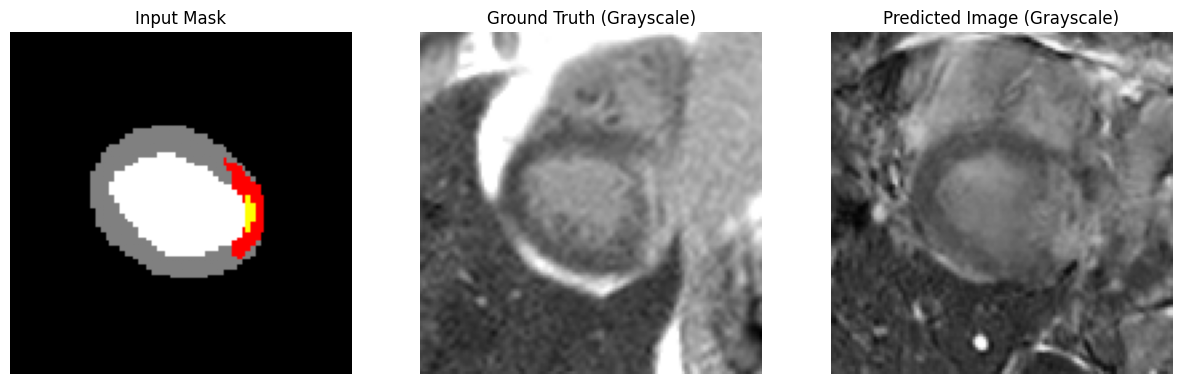

Step: 149k
....................................................................................................
[Loss Check @ step 150000]: avg_gen_total_loss over last 1k: 42.9798
Appended 10000 new loss records.


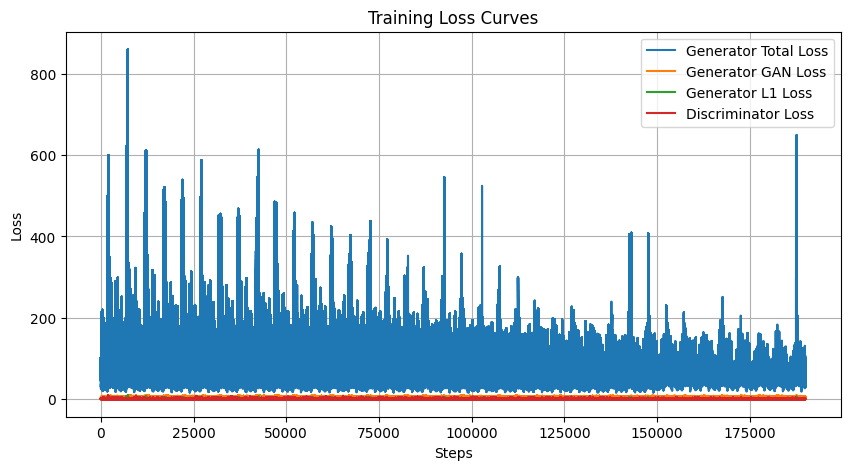

In [44]:
fit(train_dataset, test_dataset, steps=150000)

No new loss data to save.


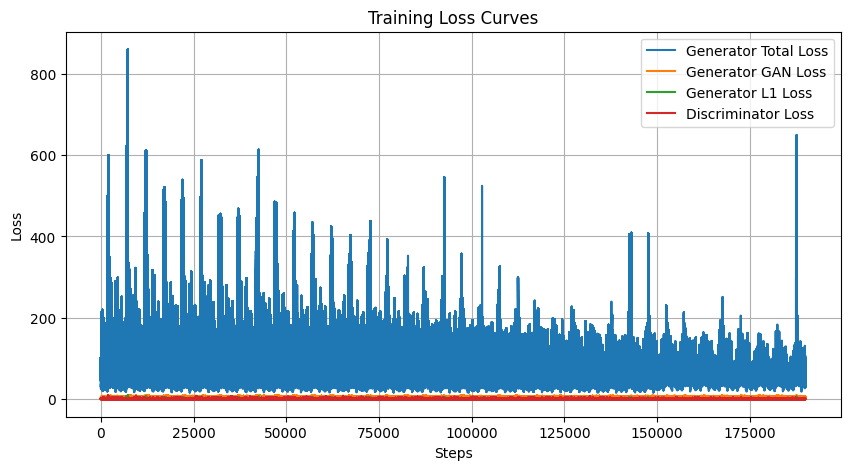

In [45]:
save_loss_to_drive()
plot_loss()

In [46]:
# Define a save path in Google Drive
save_dir = '/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/last_last_model/'


In [47]:
# Save the entire model to the specified directory
model_save_path = os.path.join(save_dir, 'weightd_trained_model.h5')
generator.save(model_save_path)  # Save the generator model
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/last_last_model/weightd_trained_model.h5


In [48]:
# Save the entire model to the specified directory
model_save_path = os.path.join(save_dir, 'D_weightd_trained_model.h5')
discriminator.save(model_save_path)  # Save the generator model
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/last_last_model/D_weightd_trained_model.h5


In [49]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(98):
  generate_images(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.